# Tutorial 2 - MicaSense library

This tutorial assumes you have gone through the [basic setup](./Micasense Image Processing Setup.ipynb) and builds on the basic radiance, irradiance, and reflectance concepts and code covered in the [first tutorial](./MicaSense Image Processing Tutorial 1.ipynb). 

In this tutorial, we will cover usage of the MicaSense python library to access images and groups of images.  Most of the processing details are hidden away in the library, but the library code is open and available in the git repository. 

# Library Components

In the first tutorial, we introduced `micasense.utils` which provided some helper functions for single image manipulation, and `micasense.plotutils` which provided some plotting helpers.

For this second tutorial, we are going to introduce the usage of the included micasense libraries for opening, converting, and displaying images. This will allow us to discuss and visualize results at a high level, while the underlying source code is available for those interested in the implementation details.  In some cases, the libraries themselves may be enough to implement a custom workflow without the need to re-implement or translate the code to another system or language.

The library code provides some basic classes to manage image data.  At the highest level is the `ImageSet`, which is able to load a list of files or recursively search a whole directory into data structures which are easy to access and manipulate.  `ImageSet`s are made up of `Capture`s, which hold the set of (usually 5) images as they are simultaneously gathered by the RedEdge camera.  Within `Capture`s are `Image`s, which hold a single image file and allow easy access to the image metadata.  The `Image` class also provides the ability to extract metadata from individual images and to convert individual images in similar ways to those described in the first tutorial. 

For the rest of this article, we will look at each of the objects available starting with the single `Image` object, and work our way up to the whole `ImageSet`.  Each section in this article is standalone, and can be copied into another workbook or edited in place to explore more of the functions associated with that object.

## micasense.Image

An image is the lowest level object. It represents the data in a single tiff file as taken by the camera.  `Image` objects expose a set of data retrieval methods which provide access to raw, radiance, and reflectance corrected images, and to undistort any of those images. Note that when retrieving image data from an `Image` object, the data is stored internally in the object, increasing the object's memory footprint. If operating on a large number of images, it may be necessary to release this data memory after each image is processed to limit the program memory footprint. This can be done by calling the `Image.clear_image_data()` method.

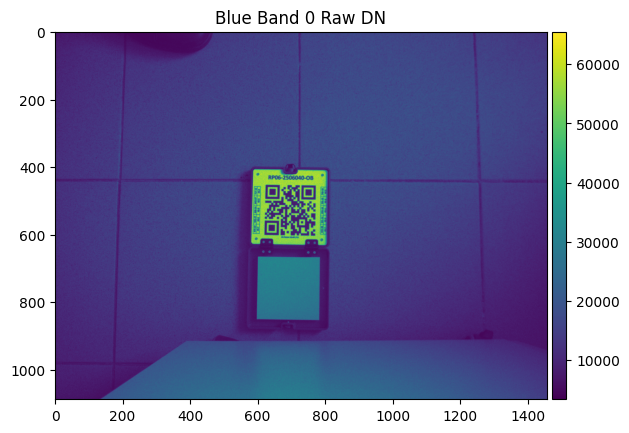

In [4]:
import os
import micasense.image as image
%matplotlib inline

#image_path = os.path.join('.','data','ALTUM','IMG_0000_1.tif')
image_path = os.path.join('..','data','tabakas_ground','IMG_0008_1.tif')

img = image.Image(image_path)
img.plot_raw();

### Accessing `Image` Metadata

Metadata for each image is available in the `Image.meta` parameter.  This object is a `micasense.Metadata` object and can be accessed directly for image specific metadata extraction. Below, we print the same metadata values as we did in Tutorial #1, but using direct access to the `Metadata` object parameters.

A notebook for experimenting with the `Image` class can be found [here](Images.ipynb).

In [5]:
print('{0} {1} firmware version: {2}'.format(img.meta.camera_make(),
                                             img.meta.camera_model(), 
                                             img.meta.firmware_version()))
print('Exposure Time: {0} seconds'.format(img.meta.exposure()))
print('Imager Gain: {0}'.format(img.meta.gain()))
print('Size: {0}x{1} pixels'.format(img.meta.image_size()[0],
                                    img.meta.image_size()[1]))
print('Band Name: {0}'.format(img.meta.band_name()))
print('Center Wavelength: {0} nm'.format(img.meta.center_wavelength()))
print('Bandwidth: {0} nm'.format(img.meta.bandwidth()))
print('Capture ID: {0}'.format(img.meta.capture_id()))
print('Flight ID: {0}'.format(img.meta.flight_id()))

MicaSense RedEdge-P firmware version: v1.4.7
Exposure Time: 0.012736278 seconds
Imager Gain: 16.0
Size: 1456x1088 pixels
Band Name: Blue
Center Wavelength: 475 nm
Bandwidth: 32 nm
Capture ID: TJ8NNdhAM7m781NQte65
Flight ID: ryvjNb8gKGbefJVKuhMK


## micasense.Capture

The `Capture` class is a container for `Image`s which allows access to metadata common to the group of images. The internal `Image` objects are accessible via the `capture.images` properties, and images in this list are kept sorted by the `band` property.  Data which is different for each image can be accessed through composite methods, such as the `capture.dls_irradiance()` method, which returns a list of irradiances in band order.

In [6]:
from micasense.image import Image
import os

image_path = os.path.join('..', 'data', 'tabakas_ground', 'IMG_0008_1.tif')
img = Image(image_path)


print(f"Library path: {os.path.dirname(micasense.__file__)}")
# Display the actual metadata object contents
print(f"Bands: {img.meta.band_name()}")
print(f"Dimensions: {img.meta.image_size()}")
print(f"Camera Model: {img.meta.camera_model()}")

NameError: name 'micasense' is not defined

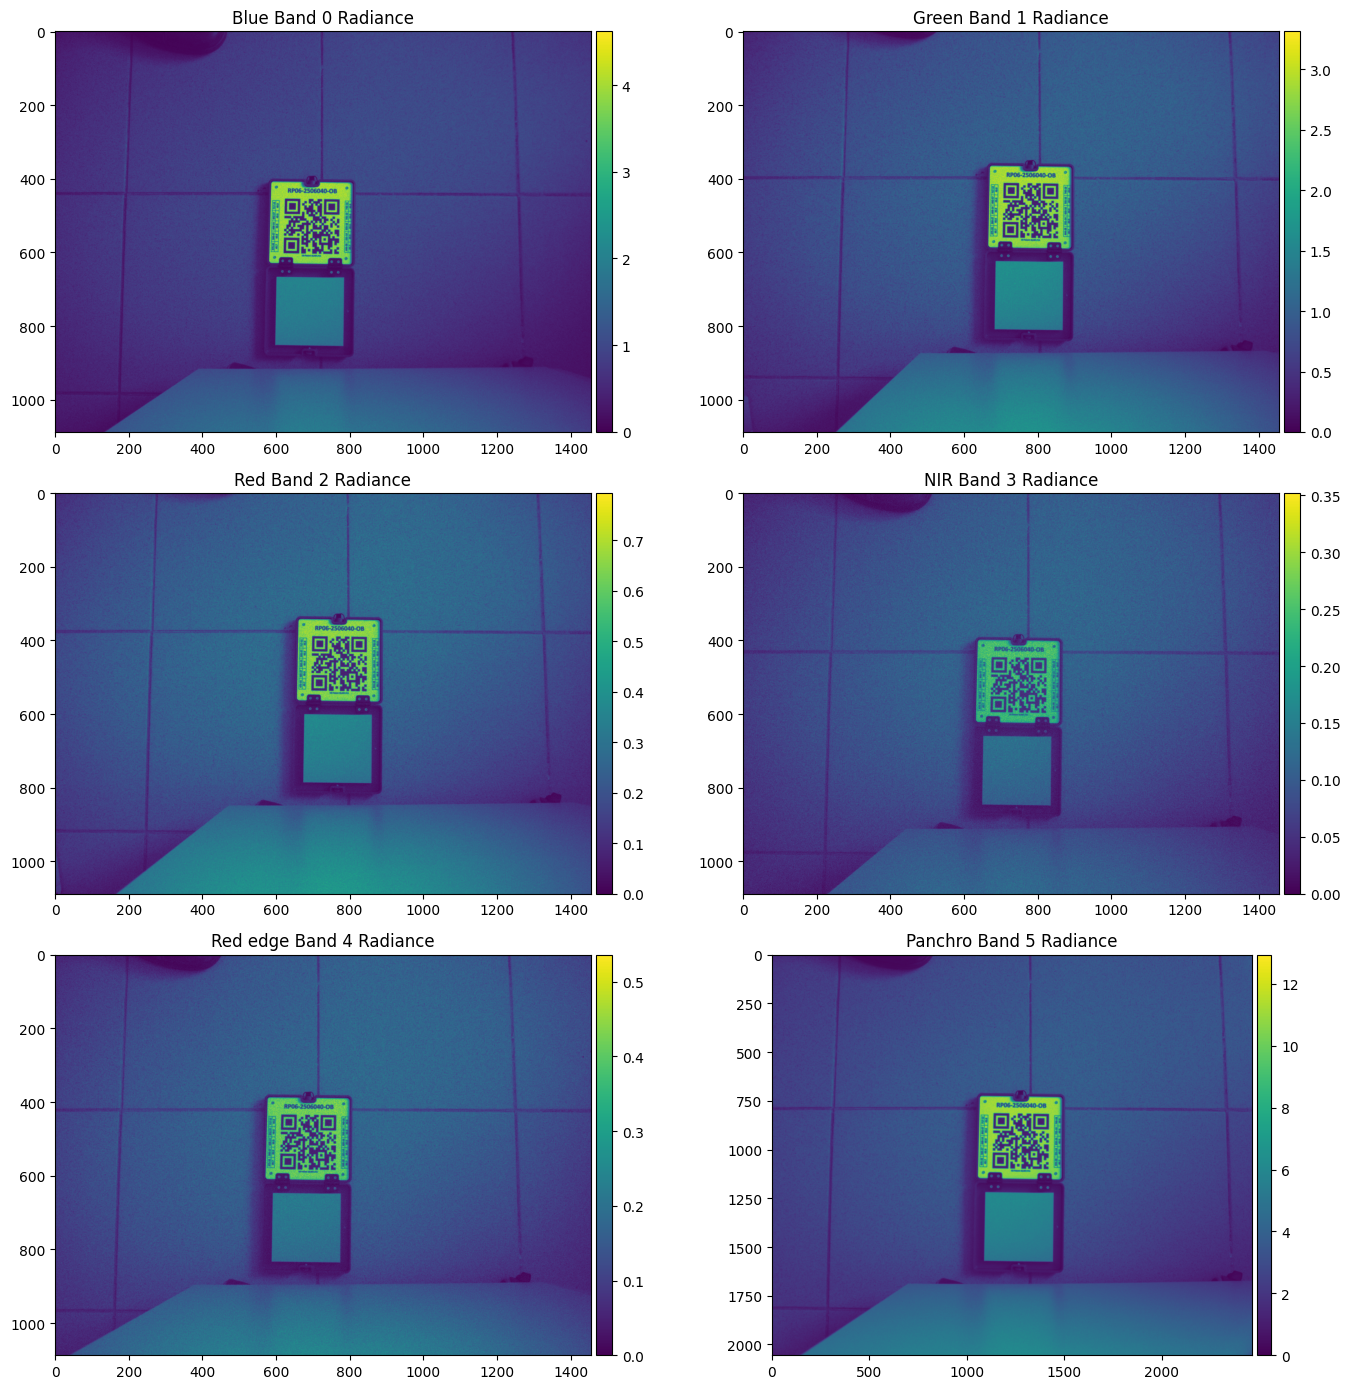

In [7]:
import os, glob
import micasense.capture as capture

#images_path = os.path.join('.','data','ALTUM')
#image_names = glob.glob(os.path.join(images_path,'IMG_0000_*.tif'))

images_path = os.path.join('..','data','tabakas_ground')
image_names = glob.glob(os.path.join(images_path,'IMG_0008_*.tif'))

cap = capture.Capture.from_filelist(image_names)
cap.plot_radiance();

### Acessing `Capture` metadata

Metadata which is common to all captures can be accessed via methods on the `Capture` object.  Metadata which varies between the images of the capture, such as DLS information, is available as lists accessed from the capture object. 

<div class="alert alert-info">
  <strong>Note:</strong> The lists returned from metadata access on the `Capture` object are returned in `band_index` order.  All images within a capture are sorted by the image `band_index`, and all lists adhere to this ordering.  This ordering is consistent with the number at the end of each filename of a RedEdge image.
</div>

Below we plot the raw and tilt compensated DLS irradiance by center wavelength and by band name.


['Blue', 'Green', 'Red', 'NIR', 'Red edge', 'Panchro']


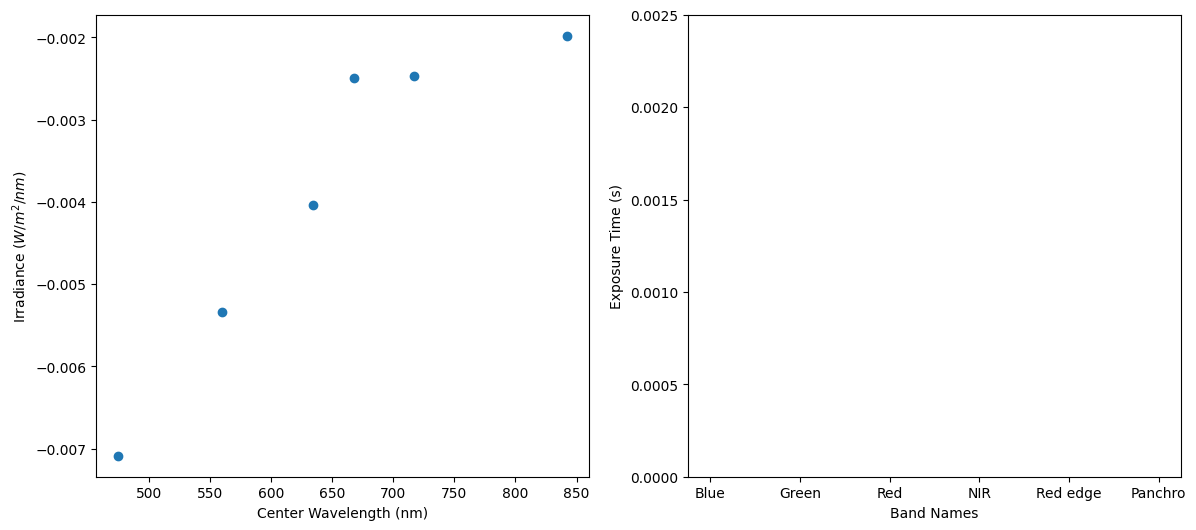

In [8]:
import matplotlib.pyplot as plt

print(cap.band_names())
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(cap.center_wavelengths(), cap.dls_irradiance())
plt.ylabel('Irradiance $(W/m^2/nm)$')
plt.xlabel('Center Wavelength (nm)')
plt.subplot(1,2,2)
plt.scatter(cap.band_names(), [img.meta.exposure() for img in cap.images])
plt.xlabel('Band Names')
plt.ylim([0,2.5e-3])
plt.ylabel('Exposure Time (s)')
plt.show()

A notebook for experimenting with the `Capture` class can be found [here](Captures.ipynb).

## micasense.Panel

The `Panel` class is a helper class which can automatically extract panel information from MicaSense calibrated reflectance panels by finding the QR code within an image and using the QR Code location and orientation information to find the lambertian panel area.  The class then allows extraction of statistics from the panel area such as mean raw values, mean radiance, standard deviation, and the number of saturated pixels in the panel region. The panel object can be included standalone, or used within the context of a `Capture` object.

<div class="alert alert-info">
  <strong>Note:</strong> For the automatic panel QR code finding functions of the library to work, zbar and it's python bindings must be installed. We have made every effort to ensure this fails gracefully if zbar isn't available. Unfortunately zbar is only available using Python 2.7, not Python 3.  If you're using Python 3.x, the code available in '/micasense/panel.py' shows how to find QR codes in images and to find the panel area from the QR location.  We're currently looking for Python QR code finding options that work across platforms and Python versions, let us know if you have one that supports location!
</div>

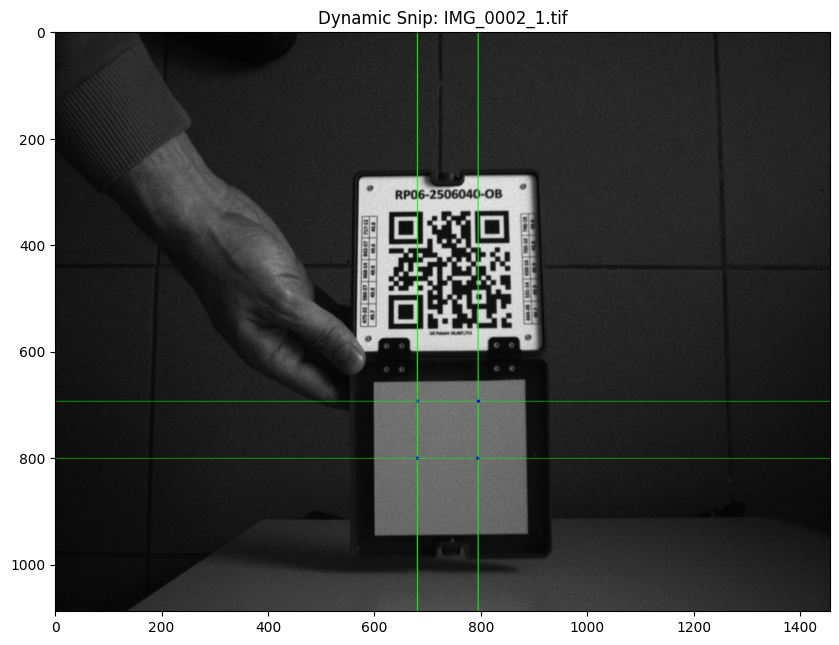

Points found: [[681, 694], [680, 801], [794, 801], [795, 694]]


In [9]:
import os
import cv2
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import micasense.image as image
import micasense.panel as panel

def get_dynamic_meta(path):
    # -G1 groups tags by specific location (e.g., XMP-micasense)
    cmd = ['exiftool', '-json', '-G1', path]
    return json.loads(subprocess.check_output(cmd))[0]

def find_tag(meta, tag_name):
    """Finds a tag even if the group prefix varies."""
    for key, value in meta.items():
        if tag_name in key:
            return value
    return None

# 1. Load current image
#image_path = os.path.join('.','data','tabakas_ground','IMG_0008_1.tif')
image_path = os.path.join('..','data','tabakas_hand','IMG_0002_1.tif')

img = image.Image(image_path)
meta = get_dynamic_meta(image_path)

# 2. Extract coordinates dynamically 
reflect_str = find_tag(meta, 'ReflectArea')
if reflect_str is None:
    raise ValueError(f"Could not find ReflectArea in {image_path}")
corners = np.array([int(x) for x in str(reflect_str).split(',')]).reshape(-1, 2)

# 3. Extract BlackLevel dynamically 
black_val = find_tag(meta, 'BlackLevel')
# Handle '3818 3818 3818 3818' string or list 
black_level = float(str(black_val).split()[0]) if black_val else 3818.0

# 4. Patch object for RedEdge-P
img.black_level = black_level
img.panel_serial = str(find_tag(meta, 'PanelSerial'))
img.vignette = lambda: (np.ones(img.raw().shape), None, None)
img.radiance = lambda: (1.0 / (img.gain * img.exposure_time)) * (img.raw() - img.black_level)

# 5. Build display with full-image crosshairs
rad = img.radiance()
img_8bit = np.clip(255.0 * (rad - rad.min()) / (rad.max() - rad.min()), 0, 255).astype('uint8')
display_img = cv2.cvtColor(img_8bit, cv2.COLOR_GRAY2RGB)
h, w = display_img.shape[:2]

for (x, y) in corners:
    cv2.line(display_img, (0, y), (w, y), (0, 255, 0), 1) # Full horizontal
    cv2.line(display_img, (x, 0), (x, h), (0, 255, 0), 1) # Full vertical
    cv2.circle(display_img, (x, y), 3, (0, 0, 255), -1)

plt.figure(figsize=(10, 10))
plt.imshow(display_img)
plt.title(f"Dynamic Snip: {os.path.basename(image_path)}")
plt.show()

print(f"Points found: {corners.tolist()}")

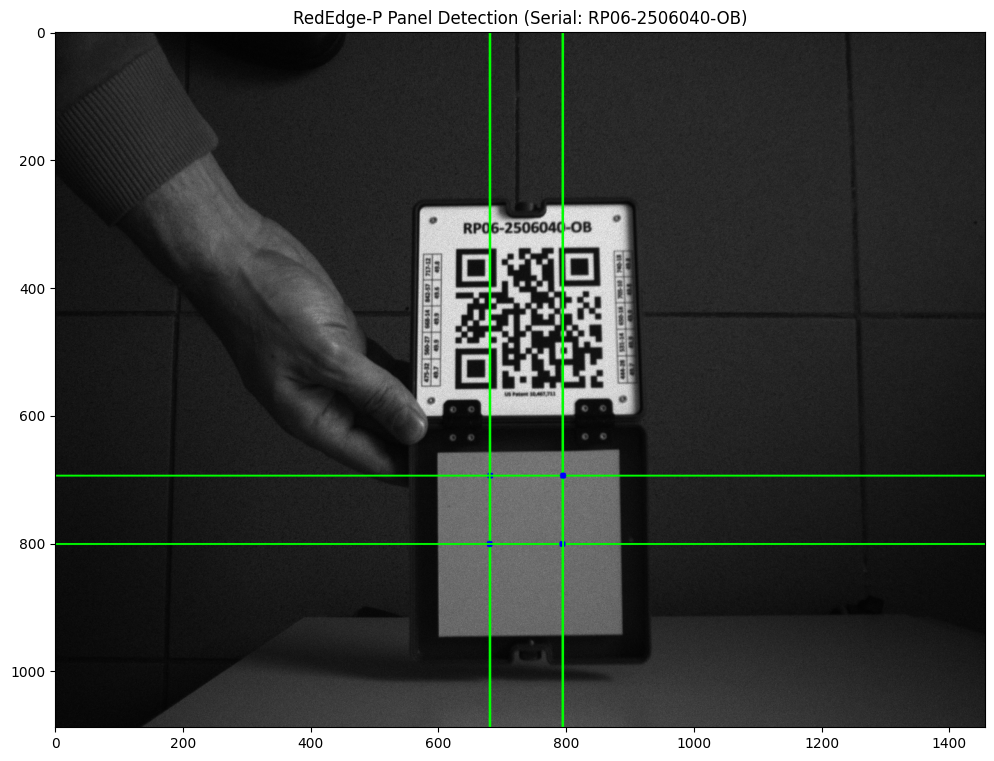

Panel Corners Coordinates:
[[681 694]
 [680 801]
 [794 801]
 [795 694]]


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.image as image
import micasense.panel as panel

# 1. Load Image and Setup
image_path = os.path.join('..','data','tabakas_hand','IMG_0002_1.tif')
img = image.Image(image_path)

# 2. Patch Metadata and Methods for RedEdge-P Compatibility
img.black_level = 3818.0 
img.panel_serial = "RP06-2506040-OB"

def fixed_vignette():
    shape = img.raw().shape
    return np.ones(shape), np.zeros(shape), np.zeros(shape)

def fixed_radiance(force_recompute=False):
    # Simplified radiance for RedEdge-P [1,0,0] calibration
    return (1.0 / (img.gain * img.exposure_time)) * (img.raw() - img.black_level)

img.vignette = fixed_vignette
img.radiance = fixed_radiance

# 3. Create a visible 8-bit image manually
rad_img = img.radiance()
img_min, img_max = rad_img.min(), rad_img.max()
img_8bit = np.clip(255.0 * (rad_img - img_min) / (img_max - img_min), 0, 255).astype('uint8')

# 4. Initialize Panel and Inject Fixed Image
try:
    pnl = panel.Panel(img)
    pnl.gray8b = img_8bit # Fix the "no picture" issue
    
    # 5. Create the Crosshair Display
    # Convert grayscale to RGB for colored lines
    display_img = cv2.cvtColor(pnl.gray8b, cv2.COLOR_GRAY2RGB)
    corners = pnl.panel_corners()
    
    if corners is not None:
        h, w = display_img.shape[:2]
        for pt in corners.astype(int):
            x, y = pt[0], pt[1]
            # Draw Horizontal Line (whole width)
            cv2.line(display_img, (0, y), (w, y), (0, 255, 0), 2)
            # Draw Vertical Line (whole height)
            cv2.line(display_img, (x, 0), (x, h), (0, 255, 0), 2)
            # Mark the intersection point
            cv2.circle(display_img, (x, y), 5, (0, 0, 255), -1)

    # 6. Final Plot
    plt.figure(figsize=(12, 12))
    plt.title(f"RedEdge-P Panel Detection (Serial: {pnl.serial})")
    plt.imshow(display_img)
    plt.show()

    print(f"Panel Corners Coordinates:\n{corners}")
    
except Exception as e:
    print(f"Failed to process RedEdge-P image: {e}")

Panel Found: True


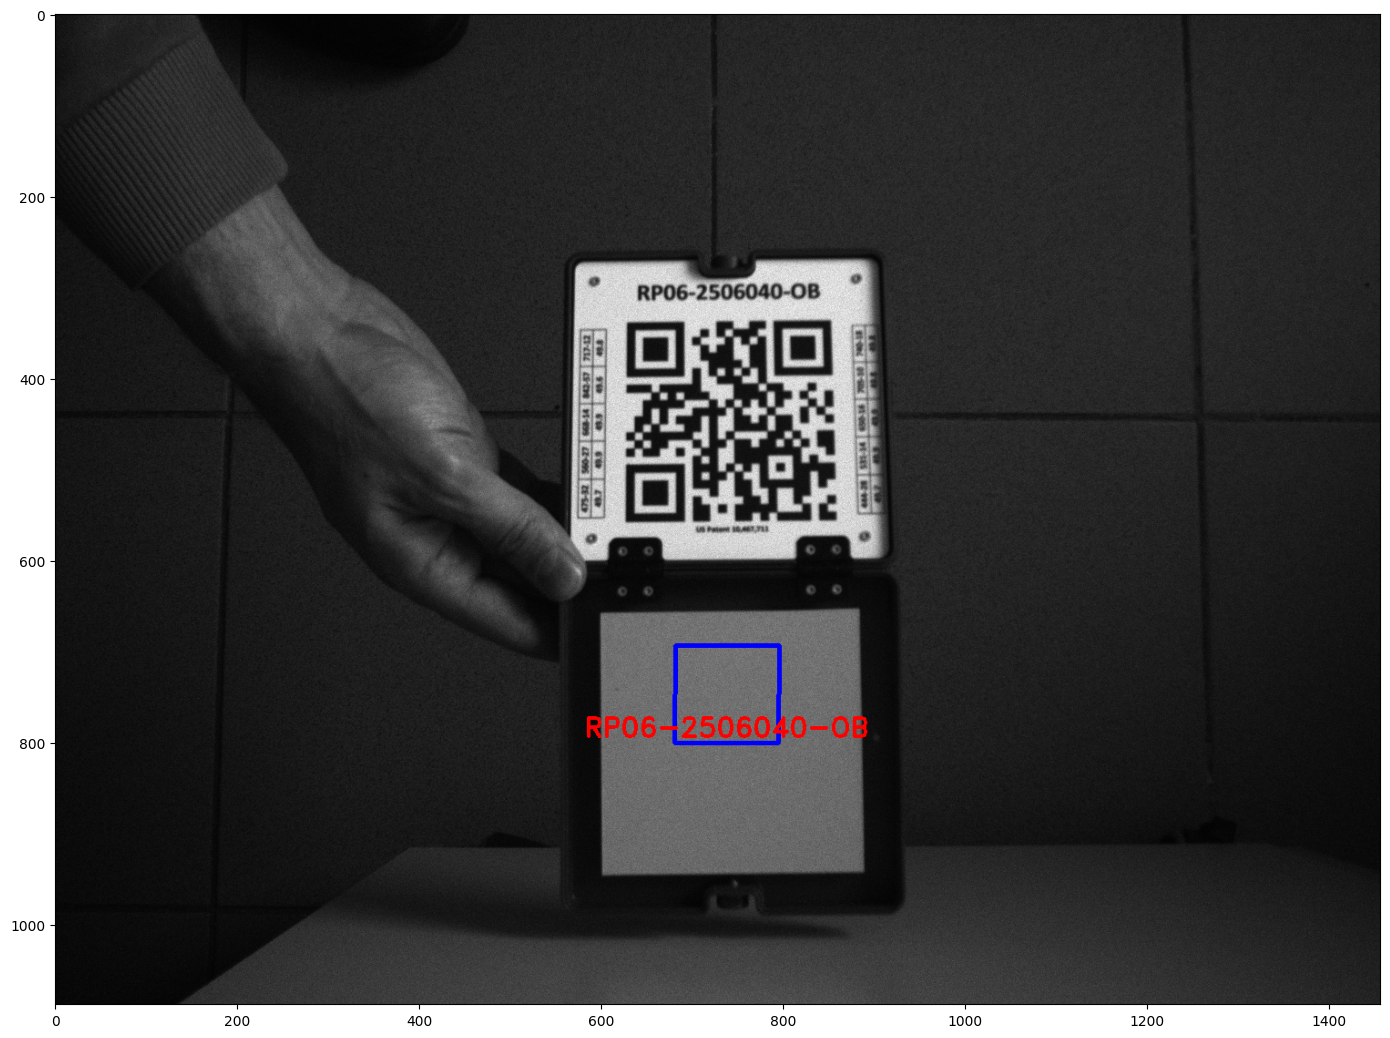

In [12]:
##visai veikia

import cv2
import numpy as np

# ... (Previous img loading and metadata extraction code) ...

# 1. Apply the fixes we established
img.black_level = 3818.0 
img.panel_serial = "RP06-2506040-OB"

def fixed_vignette():
    return np.ones(img.raw().shape), np.zeros(img.raw().shape), np.zeros(img.raw().shape)

def fixed_radiance(force_recompute=False):
    # L = (Raw - Black) / (Gain * Exposure)
    return (1.0 / (img.gain * img.exposure_time)) * (img.raw() - img.black_level)

img.vignette = fixed_vignette
img.radiance = fixed_radiance

# 2. THE IMAGE DISPLAY FIX: Create the 8-bit image manually before calling Panel
# This bypasses the broken 'cv2.convertScaleAbs' inside panel.py
rad_img = img.radiance()
bias = rad_img.min()
scale = rad_img.max() - bias

# Normalize the radiance to a 0-255 range
img_8bit = np.clip(255.0 * (rad_img - bias) / scale, 0, 255).astype('uint8')

# 3. Initialize Panel and FORCE the display image
try:
    pnl = panel.Panel(img)
    pnl.gray8b = img_8bit # Manually inject the working 8-bit image
    
    print(f"Panel Found: {pnl.panel_detected()}")
    pnl.plot() # This should now show the picture
except Exception as e:
    print(f"Plotting failed: {e}")

Panel Found: True
Panel Serial: RP06-2506040-OB
Mean Raw Value: 29936.30


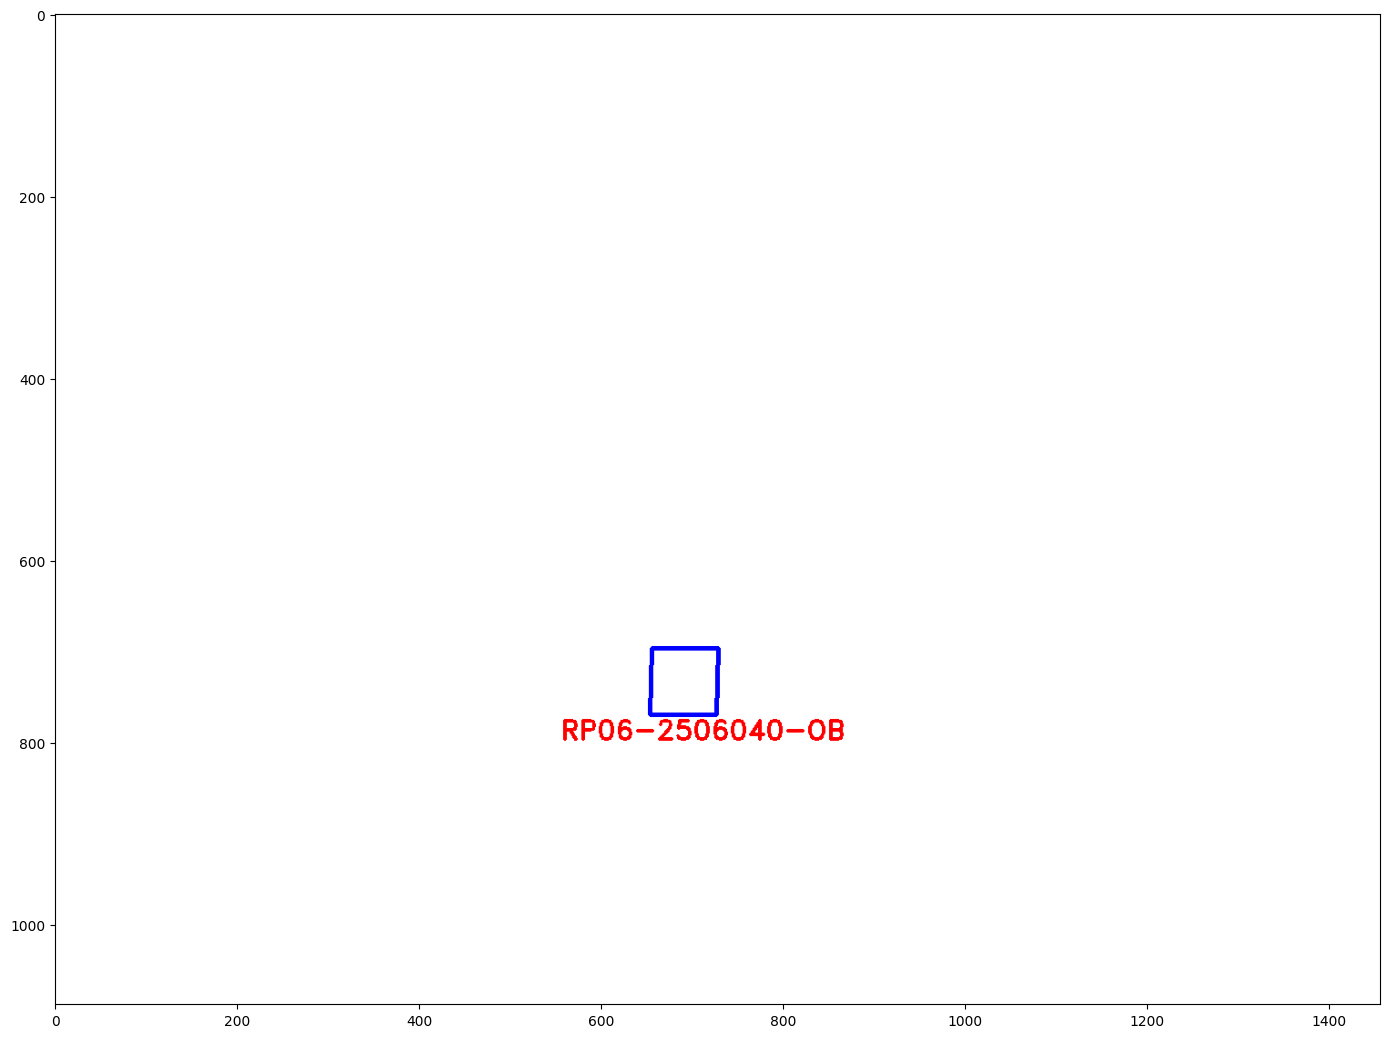

In [14]:
### veikia bet be paveiksliuko

import numpy as np
import micasense.image as image
import micasense.panel as panel

# 1. Load the image
image_path = os.path.join('..','data','tabakas_ground','IMG_0008_1.tif')
img = image.Image(image_path)

# --- THE FIX: MONKEY PATCHING ---

# Fix 1: Force the Black Level and Panel Serial from your Exif results
img.black_level = 3818.0 
img.panel_serial = "RP06-2506040-OB"

# Fix 2: Override the broken vignette function (RedEdge-P uses 2D or is factory-flat)
def fixed_vignette():
    # Return 1s in the exact shape of the RedEdge-P sensor (1088, 1456)
    shape = img.raw().shape
    return np.ones(shape), np.zeros(shape), np.zeros(shape)

# Fix 3: Override radiance to handle RedEdge-P [1,0,0] calibration
def fixed_radiance(force_recompute=False):
    # L = V * R * (Raw - Black) -> Since R is 1.0/(gain*exp), we simplify
    raw = img.raw()
    vignette, _, _ = img.vignette()
    return vignette * (1.0 / (img.gain * img.exposure_time)) * (raw - img.black_level)

# Inject the fixed functions into the existing object
img.vignette = fixed_vignette
img.radiance = fixed_radiance

# --- RUN PANEL DETECTION ---

try:
    # Use ignore_autocalibration=True if you want to force QR scanning
    pnl = panel.Panel(img)
    
    print(f"Panel Found: {pnl.panel_detected()}")
    print(f"Panel Serial: {pnl.serial}")
    
    # Calculate stats
    mean, std, count, _ = pnl.raw()
    print(f"Mean Raw Value: {mean:.2f}")
    
    pnl.plot()
except Exception as e:
    print(f"Process failed: {e}")

In [16]:
import os
import subprocess
import json
import pprint

image_path = os.path.join('..','data','ALTUM','IMG_0000_1.tif')

# Define your RedEdge-P image path
#image_path = os.path.join('.', 'data', 'tabakas_ground', 'IMG_0008_1.tif')

def extract_all_metadata(path):
    """
    Extracts all metadata from the image using the external exiftool.
    The -G flag shows group names (e.g., EXIF, XMP, MakerNotes).
    """
    try:
        # -j returns JSON, -G prints group names (e.g., [XMP-micasense])
        cmd = ['exiftool', '-G', '-j', path]
        output = subprocess.check_output(cmd)
        return json.loads(output)[0]
    except Exception as e:
        return {"Error": str(e)}

metadata = extract_all_metadata(image_path)

# Filter and print specific calibration-related groups
print(f"--- Full Metadata for: {os.path.basename(image_path)} ---")
pprint.pprint(metadata)

# Specifically look for the tags causing the library to crash
print("\n--- Key Calibration Tags Found ---")
for key, value in metadata.items():
    if any(word in key for word in ['Vignette', 'Radiometric', 'Black', 'Panel', 'Pressure']):
        print(f"{key}: {value}")

--- Full Metadata for: IMG_0000_1.tif ---
{'Composite:Aperture': 1.8,
 'Composite:CircleOfConfusion': '0.006 mm',
 'Composite:FOV': '49.6 deg',
 'Composite:FocalLength35efl': '8.0 mm (35 mm equivalent: 38.9 mm)',
 'Composite:GPSAltitude': '8.4 m Below Sea Level',
 'Composite:GPSLatitude': '47 deg 42\' 13.10" N',
 'Composite:GPSLongitude': '122 deg 8\' 29.12" W',
 'Composite:GPSPosition': '47 deg 42\' 13.10" N, 122 deg 8\' 29.12" W',
 'Composite:HyperfocalDistance': '5.76 m',
 'Composite:ImageSize': '2064x1544',
 'Composite:Megapixels': 3.2,
 'Composite:ScaleFactor35efl': 4.9,
 'Composite:ShutterSpeed': '1/2360',
 'Composite:SubSecModifyDate': '2022:04:06 20:00:32.754172270',
 'EXIF:BitsPerSample': 16,
 'EXIF:BlackLevel': '4800 4800 4800 4800',
 'EXIF:BlackLevelRepeatDim': '2 2',
 'EXIF:Compression': 'Uncompressed',
 'EXIF:CreateDate': '2022:04:06 20:00:32',
 'EXIF:DateTimeOriginal': '2022:04:06 20:00:32',
 'EXIF:ExifVersion': '0230',
 'EXIF:ExposureProgram': 'Program AE',
 'EXIF:Exposu

Panel found: True
Panel serial: RP06-2506040-OB
QR Code Corners:
None
Panel mean raw pixel value: 29936.29866765359
Panel raw pixel standard deviation: 1198.5852521112279
Panel region pixel count: 5404
Panel region saturated pixel count: 5404


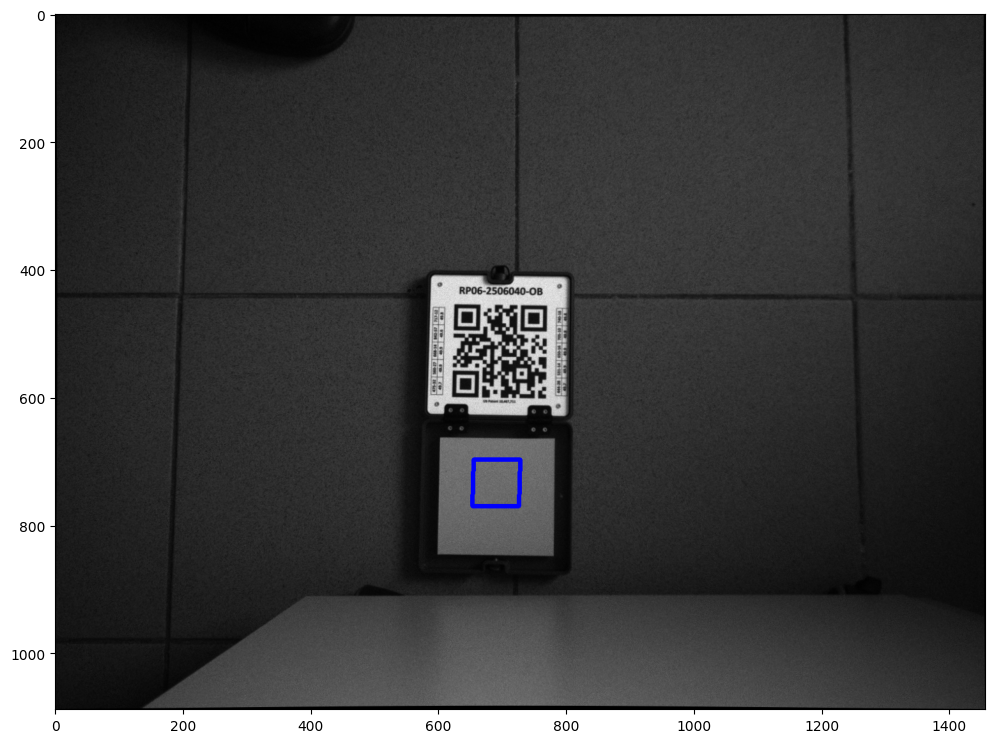

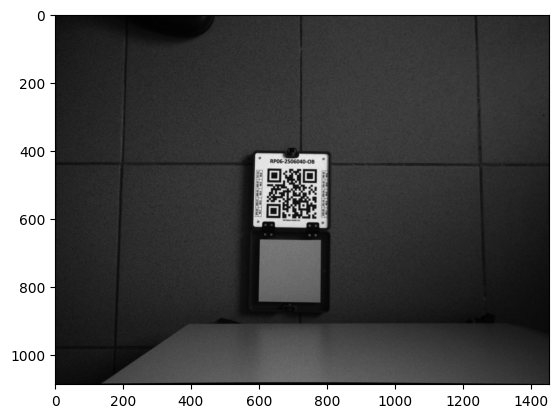

Panel Region Corners:
[[655 697]
 [653 770]
 [726 770]
 [728 697]]


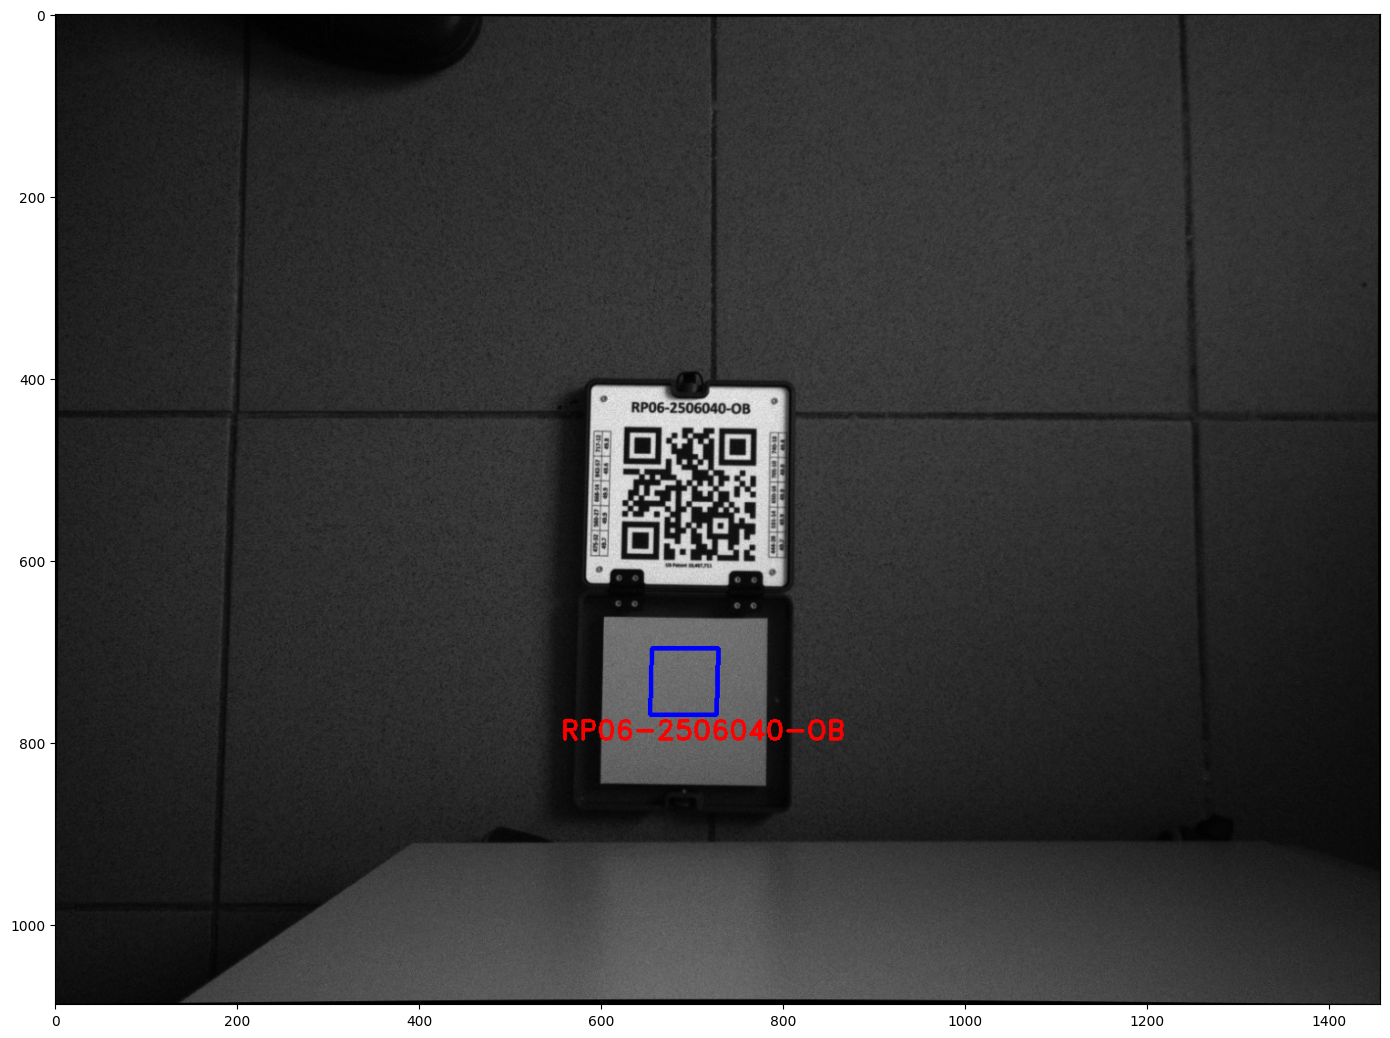

In [17]:
import cv2
import os
import matplotlib.pyplot as plt
import micasense.image as image
import micasense.panel as panel

#image_path = os.path.join('.','data','ALTUM','IMG_0000_1.tif')
image_path = os.path.join('..','data','tabakas_ground','IMG_0008_1.tif')


img = image.Image(image_path)
pnl = panel.Panel(img)



#pnl = panel.Panel(img, ignore_autocalibration=True)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

corners = pnl.panel_corners()
display_img = cv2.cvtColor(pnl.gray8b, cv2.COLOR_GRAY2RGB)
if corners is not None:
    cv2.drawContours(display_img, [corners.astype(int)], -1, (0, 0, 255), 5)
    
plt.figure(figsize=(12, 12))
plt.imshow(display_img)
#plt.axis('off')
plt.show()

# This is the 8-bit version pyzbar actually scans
plt.imshow(pnl.gray8b, cmap='gray')
plt.show()
print("Panel Region Corners:\n{}".format(pnl.panel_corners()))

pnl.plot();

A notebook for experimenting with the `Panel` class can be found [here](Panels.ipynb)

## micasense.ImageSet

An `ImageSet` contains a group of `Capture`s. The captures can be loaded from image object, from a list of files, or by recursively searching a directory for images.

Loading an `ImageSet` can be a time consuming process.  It uses python multithreading under the hood to maximize cpu usage on multi-core machines.

In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=1)
display(f)
def update_f(val):
    f.value=val

import micasense.imageset as imageset
import os
images_dir = os.path.join('.','data','ALTUM')

imgset = imageset.ImageSet.from_directory(images_dir, progress_callback=update_f)

for cap in imgset.captures:
    print ("Opened Capture {} with bands {}".format(cap.uuid,[str(band) for band in cap.band_names()]))

## Extended ImageSet examples

A large group of images captured over a central California orchard are available for [download here](https://s3-us-west-2.amazonaws.com/sample.micasense.com/imageprocessing/RedEdgeImageSet.zip).

With this set extracted to a working folder, the [extended ImageSet example](./ImageSets.ipynb) notebook provides more usages of ImageSet data.

# Conclusion

In this tutorial, we have introduced the MicaSense library and provided some examples of opening Images, Captures, and ImageSets, as well as detecting and extracting panel information from images.

The next tutorial covers basic usage of DLS information, and is available [here](./MicaSense%20Image%20Processing%20Tutorial%203.ipynb)

---
Copyright (c) 2017-2019 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)